# Point cloud object detection using SECOND

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Sparsely-Embedded-Convolutional-Detection-(SECOND)-architecture" data-toc-modified-id="Sparsely-Embedded-Convolutional-Detection-(SECOND)-architecture-2">Sparsely Embedded Convolutional Detection (SECOND) architecture</a></span><ul class="toc-item"><li><span><a href="#Sparse-Convolution" data-toc-modified-id="Sparse-Convolution-2.1">Sparse Convolution</a></span></li><li><span><a href="#Angle-Loss-Regression" data-toc-modified-id="Angle-Loss-Regression-2.2">Angle Loss Regression</a></span></li></ul></li><li><span><a href="#Implementation-in-arcgis.learn" data-toc-modified-id="Implementation-in-arcgis.learn-3">Implementation in <code>arcgis.learn</code></a></span><ul class="toc-item"><li><span><a href="#For-advanced-users" data-toc-modified-id="For-advanced-users-3.1">For advanced users</a></span></li></ul></li><li><span><a href="#Best-practices-for-SECOND-workflow" data-toc-modified-id="Best-practices-for-SECOND-workflow-4">Best practices for SECOND workflow</a></span></li><li><span><a href="#References" data-toc-modified-id="References-5">References</a></span></li></ul></div>

## Introduction

The `arcgis.learn` module supports point cloud object detection as a downstream task using the Sparsely Embedded Convolutional Detection (SECOND) architecture <a href="#references">[1]</a>. This architecture enables the detection of 3D objects within a point cloud dataset, represented by 3D bounding boxes (multipatch feature class). Point cloud datasets are typically acquired using LiDAR sensors, which employ laser beams to sample the Earth's surface and generate precise x, y, and z coordinates. These points, collectively referred to as "point clouds," are commonly generated through terrestrial and airborne LiDAR surveys.

Point clouds consist of collections of 3D points that contain location information (x, y, and z coordinates) along with additional attributes such as GPS timestamps, intensity, and number of returns. Intensity reflects the strength of the returning laser pulse, while the number of returns indicates how many times a given pulse was reflected. LiDAR data can be combined with RGB (red, green, and blue) bands derived from imagery captured concurrently with the LiDAR survey.

Point cloud object detection focuses on identifying the location of an object within a scene, rather than determining the precise class code of each point that constitutes the object. For example, this technique can be used to identify objects like cars, poles, and street furniture, which generally have consistent shapes and sizes. While LiDAR points can be classified into categories such as buildings, trees, highways, and water (each with assigned numeric codes), the object detection workflow doesn't require this class code information during either training or inference. It can detect objects as 3D multipatches even within unclassified point cloud datasets.

<p align="center">
<center>
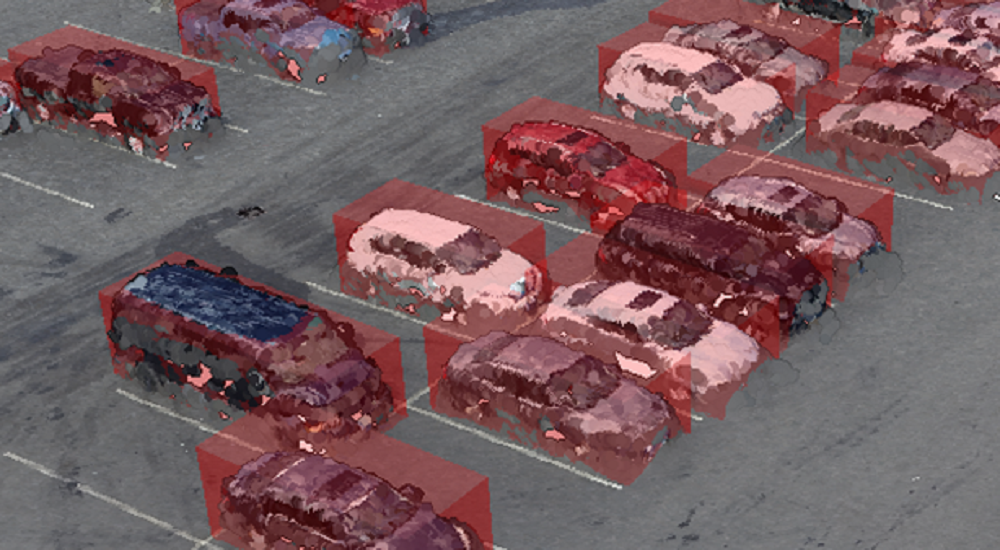
</center>
</p>
<br>
<center>Figure 1. Visualization of point cloud object detection dataset, where 3D bounding boxes represents the object's class.</center>

Point cloud object detection is a task where each bounding box (multipatch) is assigned a label representing a real-world entity (see Figure 1). Similar to traditional methods, deep learning approaches for point cloud object detection involve a training process. During training, a neural network learns from a paired dataset of point clouds (not necessarily classified) and their corresponding bounding boxes.

With that in mind, we can take a closer look at the Sparsely Embedded Convolutional Detection (SECOND) model included in `arcgis.learn` and how it can be used for point cloud object detection.<a href="#references">[1]</a>


## Sparsely Embedded Convolutional Detection (SECOND) architecture

<p align="center">
<center>
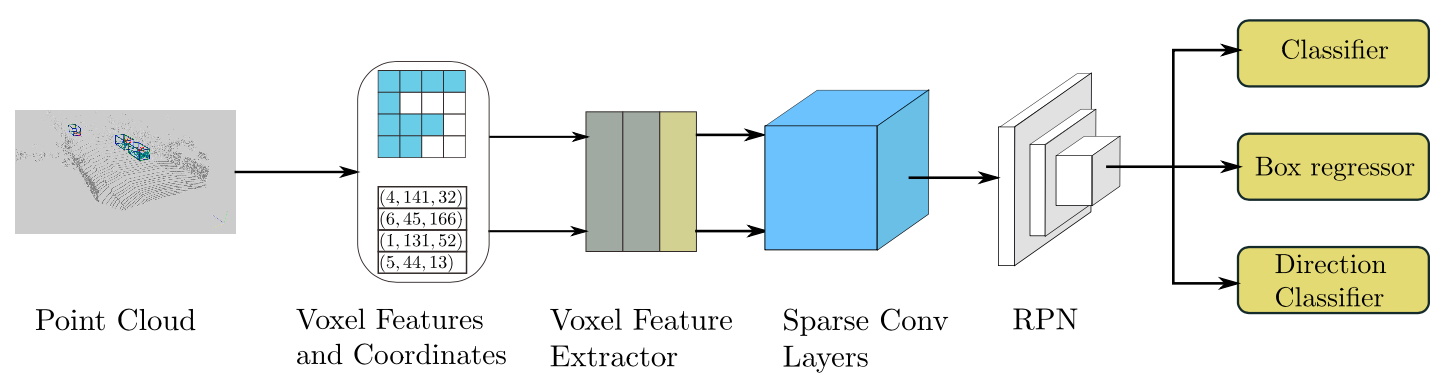</center>
</p>
<br>
<center>Figure 2. Sparsely Embedded Convolutional Detection architecture.</center>

The SECOND detector is a novel LiDAR-based 3D object detection network that significantly improves upon previous methods by leveraging sparse convolutional networks, a new angle loss regression approach, and a unique data augmentation technique.

The SECOND detector has a three-part architecture (see Figure 2):

- Voxel Feature Extractor: This component converts raw point cloud data into a voxel representation. It uses Voxel Feature Encoding (VFE) layers, which consist of a linear layer, batch normalization, and a ReLU, to extract features from each voxel.

- Sparse Convolutional Middle Extractor: This is the core of the network. It employs spatially sparse convolutional networks to extract information from the z-axis (height) and reduces the 3D data into a 2D bird's-eye view (BEV) representation. This part utilizes both submanifold convolution and standard sparse convolution for downsampling, followed by a conversion of sparse data into a dense feature map. This approach significantly improves processing speed.

- Region Proposal Network (RPN): An SSD-like RPN takes the features from the middle extractor. It uses a series of convolutional and deconvolutional layers to generate bounding box proposals, classify objects, and refine their orientations.

### Sparse Convolution

Sparse convolution is the key aspect of the SECOND's efficiency. Unlike traditional dense convolutions that compute outputs for every location in a grid, sparse convolutions only compute outputs for locations where there is input data. This is highly advantageous for LiDAR point clouds, which are inherently sparse.

It has an improved sparse convolution algorithm with a GPU-based rule generation method. This method overcomes the performance bottleneck of rule generation (determining which input points contribute to which output points) by performing it in parallel on the GPU, avoiding costly data transfers between the CPU and GPU. The rule generation algorithm first identifies unique output locations and then uses a lookup table to efficiently map input indices to output indices. By performing these computations in parallel, the improved sparse convolution achieves a substantial speedup compared to previous implementations.

### Angle Loss Regression

The angle loss regression is a crucial innovation that enhances the accuracy of orientation estimation. Previous methods for angle regression often suffered from large loss gradients when the predicted angle and the ground truth angle differed, even though these angles represent the same physical orientation of the bounding box.

The SECOND detector introduces a sine-error loss function. This formulation elegantly addresses the problem by using the sine of the angle difference, which naturally handles the periodicity of angles. The sine function ensures that the loss is small when the angle difference is close to 0 or π, reflecting the fact that these angles correspond to similar bounding box orientations. Additionally, an auxiliary direction classifier is used to distinguish between orientations that differ by π. This novel angle loss regression leads to improved orientation estimation performance.

## Implementation in `arcgis.learn`

When training a `Sparsely Embedded Convolutional Detection` (SECOND) model using `arcgis.learn`, the raw point cloud dataset in LAS files is first converted into blocks of points, containing a specific number of points along with corresponding 3D bounding boxes (as a multipatch feature class) for objects. Multiple available GP tools can be used to create 3D multipatch feature class. When creating these from a classified point cloud dataset <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/extract-objects-from-point-cloud.htm" target="_blank">Extract Objects From Point Cloud</a> tool can be very useful.

<p align="center">
<center>
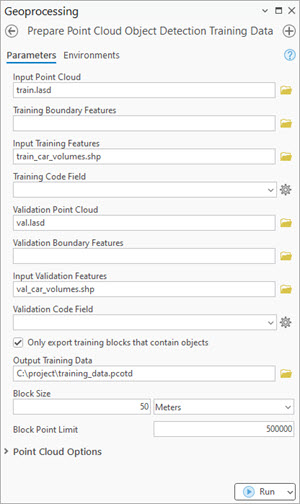</center>
</p>
<br>
<center>Figure 3. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-object-detection-training-data.htm" target="_blank">Prepare Point Cloud Object Detection Training Data</a> tool in ArcGIS Pro.</center>

For this step of exporting the data into an intermediate format, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-object-detection-training-data.htm" target="_blank">Prepare Point Cloud Object Detection Training Data</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a> (see Figure 3).

These exported blocks are used to create a `data bunch` object that is passed into the `SECOND` model for training.

```python
output_path=r'C:/project/training_data.pcotd'
data = prepare_data(output_path, dataset_type='PointCloudOD', batch_size=2)
pcd = MMDetection3D(data, model='SECOND')
pcd.fit(20)
```
After training the `SECOND` model, `average_precision_score()` method can be used to compute, per-class metrics with respect to validation data. And `save()` method can be used to save the model.

<p align="center">
<center>
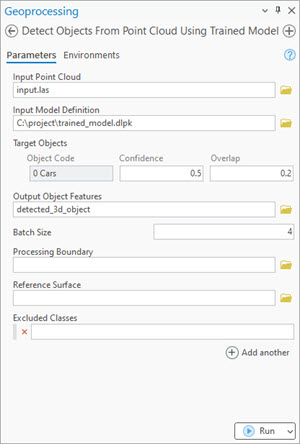</center>
</p>
<center>Figure 4. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/detect-objects-from-point-cloud-using-trained-model.htm" target="_blank">Detect Objects From Point Cloud Using Trained Model</a> tool. </center>

For inferencing, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/detect-objects-from-point-cloud-using-trained-model.htm" target="_blank">Detect Objects From Point Cloud Using Trained Model</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-point-cloud-toolset.htm" target="_blank">3D Analyst extension</a> (see Figure 4).


Detailed tool references and resources for point cloud object detection using deep learning in ArcGIS Pro can be found <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/feature-extraction-using-deep-learning.htm" target="_blank">here</a>.

### For advanced users 

We can also specify, additional parameters that directly affect the properties of the architecture itself, this can be done while initializing the `SECOND` architecture via `MMDetection3D`, by using the following parameters.

- `voxel_size` List of voxel dimensions in meter[x,y,z].


- `voxel_points` This parameter controls the maximum number of points per voxel.


- `max_voxels` List of maximum number of voxels in [training, validation].


A typical usage with respect to API looks like:

```python
pcd = MMDetection3D(data,
                    model='SECOND',
                    voxel_parms={'voxel_size': [0.2, 0.2, 0.3],
                                 'voxel_points': 10,
                                 'max_voxels':(16000, 40000),
                                }
                   )
```

## Best practices for SECOND workflow

The following tips and best practices can be used while using SECOND:

- The <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/feature-extraction-using-deep-learning.htm" target="_blank">3D deep learning tools</a> in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, takes care of the coordinate system, and related discrepancies, automatically. So, one can train a model using ArcGIS Pro on a dataset with a metric coordinate system, then use that trained model on a dataset with any other coordinate system, and vice-versa without any need for re-projection.

- High-quality labeled data will result in a better-trained model. For generalization and robustness of the trained model, significant diversity or variety should be present in the training data, in terms of geography, building architectures, terrains, object-related variations, etc.

- If the object of interest is significantly larger or smaller in size than the default value of `Block Size`, then a better value can be used for improving the results further. Like, for a dataset in a metric coordinate system, a _'warehouse'_ won't fit in a '50 meter' x '50 meter' `Block Size`, hence the `Block Size` can be increased in this case. 

- Through a series of experiments, it was found that an additional one or two `extra_features` apart from X, Y, and Z usually works best, in most cases. Over usage of 'extra attributes' for model training might reduce generalization, i.e. _'how generic the trained model will be'_. 

- Deciding which 'extra attributes' to consider, depends upon the properties of the object of interest, the nature of noise, sensor-specific attributes, etc. 

- It is recommended to filter or withheld points that belong to the 'high noise' class from the dataset.

- The default value of `max_display_point` in `show_batch()` and `show_results()` is set to '20000', keeping the rendering-related browser limitation in mind, which can occur for very dense point clouds. This value can be increased if needed, for detailed visualization, within the browser itself. 

- Parameters like, `classes_of_interest` and `min_points` are especially useful when training a model for SfM or mobile/terrestrial point clouds. In specific scenarios when the 'training data' is not small, these features can be very useful in speeding up the 'training time', improving the convergence during training, and addressing the class imbalance up to some extent.

- Fine-tuning a pretrained model is only preferred if the 'object of interest' is either same or similar, else it is not beneficial. Otherwise, fine-tuning a pretrained model can save cost, time, and compute resources while providing better accuracy/quality in results.

- Class codes can be given a meaningful name, using `class_mapping`. The names of the class codes are saved inside the model, which is automatically retrieved by <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/detect-objects-from-point-cloud-using-trained-model.htm" target="_blank">Detect Objects From Point Cloud Using Trained Model</a> tool and <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/train-point-cloud-object-detection-model.htm" target="_blank">Train Point Cloud Object Detection Model</a> tool, when a trained model is loaded.

- For fine-tuning a model with default architecture settings;  'Class Structure', 'Extra Attributes', and 'Block Point Limit' should match between the pretrained model and the exported 'training data'. Apart from this the fine-tuning data should have similar sized, 3D bounding boxes.

## References


[1] Yan, Y., Mao, Y., & Li, B. (2018). SECOND: Sparsely Embedded Convolutional Detection. Sensors, 18(10), 3337. https://doi.org/10.3390/s18103337